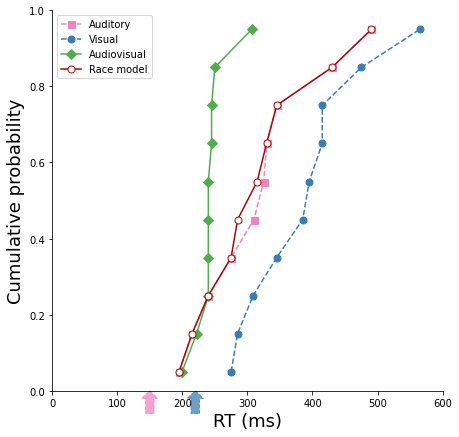

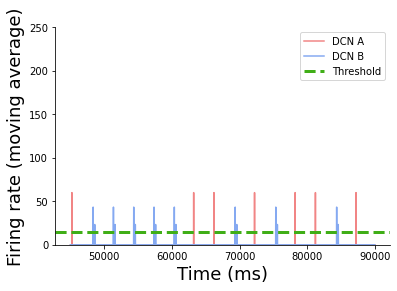

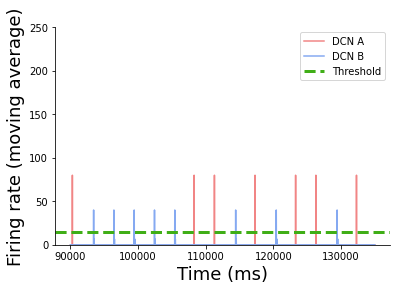

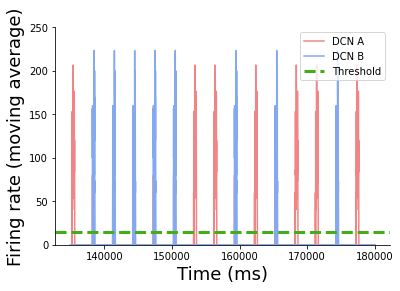

In [21]:
from src.nest.plots.generate import moving_average_plot_no_save
from src.nest.output.rates import calculate_response_times
import json
import matplotlib.pyplot as plt
import numpy as np

def cdf_calc(data):
    count, bins_count = np.histogram(data, bins=10)
    try:
        pdf = count / sum(count)
    except:
        pdf = 0
    cdf = np.cumsum(pdf)
    return bins_count, cdf

ids = [407, 408, 409, 410, 411, 412, 413, 414, 415, 416]
th = 15
plots = [
    ['0', 'Auditory', '--s', '#f781bf', '#f781bf'],
    ['1', 'Visual', '--o', '#377eb8', '#377eb8'],
    ['2', 'Audiovisual', '-D', '#4daf4a', '#4daf4a']
]

# figure, axis = plt.subplots(2, 1, figsize=(10, 10))
# plt.setp(axis, xlim=(0, 600), ylim=(0, 1.1))
# axis[0].set_title('RTs')
# axis[1].set_title('Percentiles')
plt.figure(figsize=(7, 7))
plt.xlim(0, 600)
plt.ylim(0, 1)
plt.xlabel("RT (ms)", fontsize=18)
plt.ylabel("Cumulative probability", fontsize=18)

response_times = []
rates_a = []
rates_b = []
times_a = []
times_b = []
for index, plot in enumerate(plots):
    response_times.append([])
    response_times_complete = []
    for id in ids:
        with open('output/executions/'+str(id)+'/simulations/cerebellum_simple/1/bin_rates_DCN_a_test_'+plot[0]+'.json', 'r') as j:
                bin_rates = json.loads(j.read())

        ma_rates_a, times = moving_average_plot_no_save(bin_rates)
        if(id == 416):
            rates_a.append(ma_rates_a)
            times_a.append(times)

        with open('output/executions/'+str(id)+'/simulations/cerebellum_simple/1/bin_rates_DCN_b_test_'+plot[0]+'.json', 'r') as j:
                bin_rates = json.loads(j.read())
        ma_rates_b, times = moving_average_plot_no_save(bin_rates)
        if(id == 416):
            rates_b.append(ma_rates_b)
            times_b.append(times)

        ma_rates = [abs(a-b) for a, b in zip(ma_rates_a, ma_rates_b)]

        trial_time = 3000
        bin_size = 5
        resp = calculate_response_times(ma_rates, th, trial_time, bin_size)
        for rt in resp:
            if rt == 999999999:
                response_times[index].append(rt)
            else:
                response_times[index].append(rt%1000)
                response_times_complete.append(rt%1000)

    bins_count, cdf = cdf_calc(response_times_complete)

    perc = []
    for i in np.arange(0.05, 1.0, 0.1):
        perc.append(np.percentile(response_times_complete, i*100))

    # axis[0].plot(bins_count[1:], cdf, plot[2], label=plot[1], color=plot[3], markerfacecolor=plot[4])
    # axis[1].plot(perc, np.arange(0.05, 1.0, 0.1), plot[2], label=plot[1], color=plot[3], markerfacecolor=plot[4])
    plt.plot(perc, np.arange(0.05, 1.0, 0.1), plot[2], label=plot[1], color=plot[3], markerfacecolor=plot[4], markersize=7)

race_model = np.minimum.reduce([response_times[0], response_times[1]])
race_model = [v for v in race_model if v != 999999999]
bins_count, cdf = cdf_calc(race_model)

perc = []
for i in np.arange(0.05, 1.0, 0.1):
    perc.append(np.percentile(race_model, i*100))

# axis[0].plot(bins_count[1:], cdf, '-o', label='Race model', color="crimson", markerfacecolor="white")
# axis[1].plot(perc, np.arange(0.05, 1.0, 0.1), '-o', label='Race model', color="crimson", markerfacecolor="white")
plt.plot(perc, np.arange(0.05, 1.0, 0.1), '-o', label='Race model', color="#b30000", markerfacecolor="white", markersize=7)

plt.legend()
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.arrow(150, -0.06, 0, 0.04, color="#f781bfbb", linestyle="--", width=13, head_width=25, head_length=0.02, clip_on=False)
plt.arrow(220, -0.06, 0, 0.04, color="#377eb8bb", linestyle="--", width=13, head_width=25, head_length=0.02, clip_on=False)
plt.savefig('cerebellum_rts.png', format='png', dpi=300)
plt.show()

for i in range(len(rates_a)):
    plt.figure()
    plt.ylim(0,250)
    plt.plot(times_a[i], rates_a[i], color="#f18585", label="DCN A")
    plt.plot(times_b[i], rates_b[i], color="#85a9f1", label="DCN B")
    plt.axhline(th, color="#40ae17", linestyle="--", label="Threshold", linewidth=3)
    plt.legend()
    plt.xlabel("Time (ms)", fontsize=18)
    plt.ylabel("Firing rate (moving average)", fontsize=18)
    plt.savefig('cerebellum_ma_rates'+str(i)+'.png', format='png', dpi=300)
    plt.show()